<a href="https://colab.research.google.com/github/rhiosutoyo/Teaching-Deep-Learning-and-Its-Applications/blob/main/11_3_topic_classification_TweetBERT.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Topic Classification with TweetBERT
This code implements a topic classification model using BERT (Bidirectional Encoder Representations from Transformers) with PyTorch. The goal of the model is to categorize text inputs into predefined classes based on the content of the text. The model is trained and evaluated on a subset of the Yahoo Answers Topics dataset, which includes various questions across different topics.

This implementation demonstrates a practical approach to fine-tuning BERT for a text classification task, showcasing its capability to understand and categorize text into relevant topics.

In [1]:
!pip install datasets

In [2]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification
from transformers import AdamW, get_linear_schedule_with_warmup
from sklearn.model_selection import train_test_split
from tqdm import tqdm
import matplotlib.pyplot as plt

# Download a small dataset (Yahoo Answers Topics)
from datasets import load_dataset
dataset = load_dataset('yahoo_answers_topics', split='train[:5000]')

# Mapping of class indices to class names
class_names = dataset.features['topic'].names

# Preprocess the dataset
class TopicDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            max_length=self.max_len,
            truncation=True,
            add_special_tokens=True,
            return_token_type_ids=False,
            padding='max_length',
            return_attention_mask=True,
            return_tensors='pt',
        )
        return {
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'label': torch.tensor(label, dtype=torch.long)
        }

# Load BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')

# Combine question_title and question_content for better context
dataset = dataset.map(lambda example: {'text': example['question_title'] + " " + example['question_content']})

# Split the dataset
train_texts, val_texts, train_labels, val_labels = train_test_split(
    dataset['text'], dataset['topic'], test_size=0.2, random_state=42
)

# Create Datasets and DataLoaders
train_dataset = TopicDataset(train_texts, train_labels, tokenizer, max_len=64)
val_dataset = TopicDataset(val_texts, val_labels, tokenizer, max_len=64)

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)

# Load BERT model
model = BertForSequenceClassification.from_pretrained('bert-base-uncased', num_labels=10)

# Define optimizer, scheduler, and loss function
optimizer = AdamW(model.parameters(), lr=2e-5, correct_bias=False)
total_steps = len(train_loader) * 5
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=0, num_training_steps=total_steps)
criterion = nn.CrossEntropyLoss()

# Training function
def train_epoch(model, data_loader, criterion, optimizer, scheduler):
    model.train()
    losses = []
    correct_predictions = 0
    for batch in tqdm(data_loader, desc="Training", leave=False):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        _, preds = torch.max(outputs.logits, dim=1)
        loss = criterion(outputs.logits, labels)

        correct_predictions += torch.sum(preds == labels)
        losses.append(loss.item())

        loss.backward()
        optimizer.step()
        scheduler.step()
        optimizer.zero_grad()

    return correct_predictions.double().cpu() / len(data_loader.dataset), sum(losses) / len(losses)

# Evaluation function
def eval_model(model, data_loader, criterion):
    model.eval()
    losses = []
    correct_predictions = 0
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating", leave=False):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)

            outputs = model(input_ids, attention_mask)
            _, preds = torch.max(outputs.logits, dim=1)
            loss = criterion(outputs.logits, labels)

            correct_predictions += torch.sum(preds == labels)
            losses.append(loss.item())

    return correct_predictions.double().cpu() / len(data_loader.dataset), sum(losses) / len(losses)

# Train and evaluate the model
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model = model.to(device)

history = {'train_acc': [], 'train_loss': [], 'val_acc': [], 'val_loss': []}
num_epochs = 5

for epoch in range(num_epochs):
    print(f'Epoch {epoch + 1}/{num_epochs}')
    train_acc, train_loss = train_epoch(model, train_loader, criterion, optimizer, scheduler)
    val_acc, val_loss = eval_model(model, val_loader, criterion)

    history['train_acc'].append(train_acc)
    history['train_loss'].append(train_loss)
    history['val_acc'].append(val_acc)
    history['val_loss'].append(val_loss)

    print(f'Train Loss: {train_loss:.4f} | Train Acc: {train_acc:.4f}')
    print(f'Val Loss: {val_loss:.4f} | Val Acc: {val_acc:.4f}')

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/usr/local/lib/python3.10/dist-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch

Epoch 1/5


Train Loss: 1.3018 | Train Acc: 0.5695
Val Loss: 1.0770 | Val Acc: 0.6530
Epoch 2/5


Train Loss: 0.7112 | Train Acc: 0.7720
Val Loss: 1.0258 | Val Acc: 0.6720
Epoch 3/5


Train Loss: 0.4354 | Train Acc: 0.8700
Val Loss: 1.1022 | Val Acc: 0.6630
Epoch 4/5


Train Loss: 0.2815 | Train Acc: 0.9247
Val Loss: 1.1661 | Val Acc: 0.6690
Epoch 5/5


Train Loss: 0.2083 | Train Acc: 0.9495
Val Loss: 1.1824 | Val Acc: 0.6690


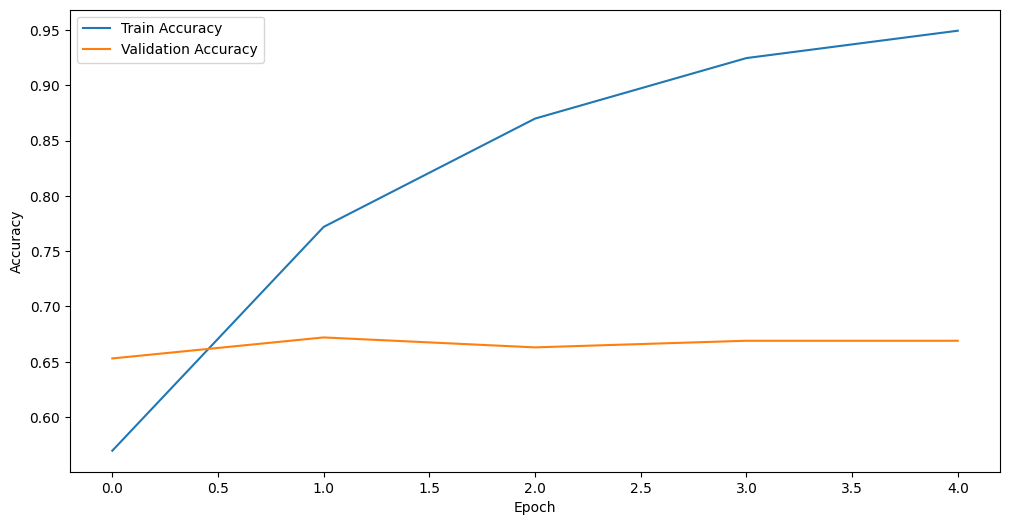

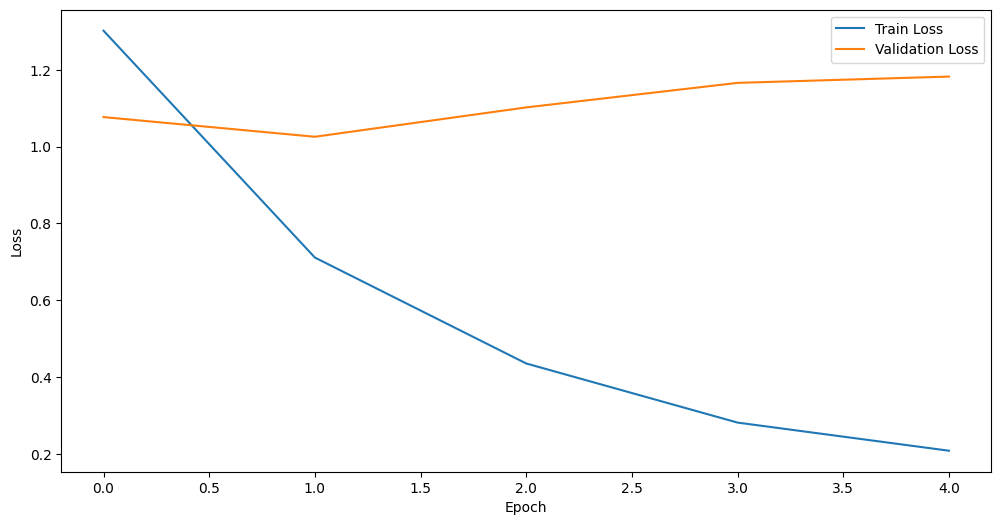

In [3]:
# Plot training history
plt.figure(figsize=(12, 6))
plt.plot([acc.cpu().numpy() for acc in history['train_acc']], label='Train Accuracy')
plt.plot([acc.cpu().numpy() for acc in history['val_acc']], label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

plt.figure(figsize=(12, 6))
plt.plot(history['train_loss'], label='Train Loss')
plt.plot(history['val_loss'], label='Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [4]:
# Test the model with one input and get class name
def predict(text, model, tokenizer, max_len=64):
    model.eval()
    encoding = tokenizer.encode_plus(
        text,
        max_length=max_len,
        truncation=True,
        add_special_tokens=True,
        return_token_type_ids=False,
        padding='max_length',
        return_attention_mask=True,
        return_tensors='pt',
    )
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    with torch.no_grad():
        outputs = model(input_ids, attention_mask)
        _, prediction = torch.max(outputs.logits, dim=1)
    return class_names[prediction.item()]

# sample_text = "How can I improve my coding skills?"
# predicted_class = predict(sample_text, model, tokenizer)
# print(f'Predicted class: {predicted_class}')

# Additional test inputs
test_inputs = [
    "How do I start learning Python programming?",
    "What are the benefits of a healthy diet?",
    "What is the best strategy for long-term investment?",
    "Can you explain the theory of relativity in simple terms?",
    "What is the capital of France?",
    "How can I improve my public speaking skills?",
    "What are the effects of global warming?",
    "Who was the first person to walk on the moon?",
    "What is the best way to prepare for a job interview?",
    "How do vaccines work?"
]

# Function to predict and print the class for each test input
def test_model_on_samples(samples, model, tokenizer):
    for i, text in enumerate(samples, 1):
        predicted_class = predict(text, model, tokenizer)
        print(f'Test Input {i}: {text}\nPredicted Class: {predicted_class}\n')

# Test the model with the sample inputs
test_model_on_samples(test_inputs, model, tokenizer)

Test Input 1: How do I start learning Python programming?
Predicted Class: Computers & Internet

Test Input 2: What are the benefits of a healthy diet?
Predicted Class: Health

Test Input 3: What is the best strategy for long-term investment?
Predicted Class: Business & Finance

Test Input 4: Can you explain the theory of relativity in simple terms?
Predicted Class: Science & Mathematics

Test Input 5: What is the capital of France?
Predicted Class: Politics & Government

Test Input 6: How can I improve my public speaking skills?
Predicted Class: Education & Reference

Test Input 7: What are the effects of global warming?
Predicted Class: Education & Reference

Test Input 8: Who was the first person to walk on the moon?
Predicted Class: Science & Mathematics

Test Input 9: What is the best way to prepare for a job interview?
Predicted Class: Business & Finance

Test Input 10: How do vaccines work?
Predicted Class: Science & Mathematics

